In [1]:
import numpy as np
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec

In [2]:
# Constants
R = 0.8               # radius of source point circle (< 1 for exterior)
M = 1000              # number of boundary points
N = 1000              # number of source points
k = 4 * np.pi         # wavenumber

# Polarisation and direction vectors
p = np.array([0., 1., 0.])
p /= np.linalg.norm(p)
d = np.array([0., 0., -1.])
d /= np.linalg.norm(d)

def E(x):
  """
  E(x) = p e^{ik d \dot x}, d orthogonal to p
    x: array-like, shape (..., 3)
    Returns an array of shape (..., 3)
  """
  return p * np.exp(1j * k * (x @ d))[..., None]

def fs(x, y):
  """
  G(x, y) = (I + ∇∇/k²) G₀(x, y), where G₀(r) = e^(ikr)/4πr
    x: boundary point(s), shape (M, 3)
    y: source point(s), shape (N, 3)
    Returns an array of shape (M, N, 3, 3)
  """
  d = x[:, None] - y[None]  # (M, N, 3)
  r = np.linalg.norm(d, axis=2, keepdims=True)  # (M, N, 1)
  kr = k * r
  kr2 = kr ** 2
  fI = (1 + 1j / kr - 1 / kr2) * np.exp(1j * kr) / r  # (M, N, 1, 1)
  fR = (1 + 3j / kr - 3 / kr2) * np.exp(1j * kr) / r  # (M, N, 1, 1)
  I = np.eye(3)[None, None, :, :]  # (1, 1, 3, 3)
  rhat = d / r  # (M, N, 3)
  return (I * fI[..., None] -
         (rhat[..., None] * rhat[..., None, :]) * fR[..., None])  # (M, N, 3, 3)

In [3]:
def sphere(npoints):
  """
  Evenly distribute points on a sphere (Fibonacci lattice)
  https://arxiv.org/pdf/0912.4540.pdf
  """
  golden_ratio = (1 + 5 ** 0.5) / 2
  i = np.arange(0, npoints)
  phi = np.arccos(1 - 2 * i / (npoints - 1))
  theta = 2 * np.pi * i / golden_ratio
  x = np.sin(phi) * np.cos(theta)
  y = np.sin(phi) * np.sin(theta)
  z = np.cos(phi)
  return np.column_stack((x, y, z))  # (npoints, 3)

# Source points
y = R * sphere(N)  # (N, 3)

# Boundary points
x = sphere(M)  # (M, 3)

In [4]:
def tangent_basis_batch(nrm):
  """
  nrm: (M,3) array
  Returns (M,2,3) tangent bases for each point
  """
  n = nrm / np.linalg.norm(nrm, axis=1, keepdims=True)
  t1 = np.cross(n, np.array([0, 0, 1]))
  norm_t1 = np.linalg.norm(t1, axis=1, keepdims=True)
  t1[norm_t1.flatten() < 1e-8] = np.array([1, 0, 0])
  t1 = t1 / np.linalg.norm(t1, axis=1, keepdims=True)
  t2 = np.cross(n, t1)
  t2 = t2 / np.linalg.norm(t2, axis=1, keepdims=True)
  return np.stack((t1, t2), axis=1)

# Compute tangent bases for all boundary points
T = tangent_basis_batch(x)  # (M, 2, 3)

# Form right-hand side vector b
# For each i, b_i = T[i] @ (-E(x[i]))
b = (T @ (-E(x)[..., None])).squeeze(-1).reshape(-1)  # shape: (2*M,)

# Form matrix A
A_blocks = (T[:, None] @ fs(x, y))  # (M, N, 2, 3)
A = A_blocks.transpose(0, 2, 1, 3).reshape(2 * M, 3 * N)

# Solve for alpha
alpha, _, _, _ = lstsq(A, b)
alpha = alpha.reshape(N, 3)

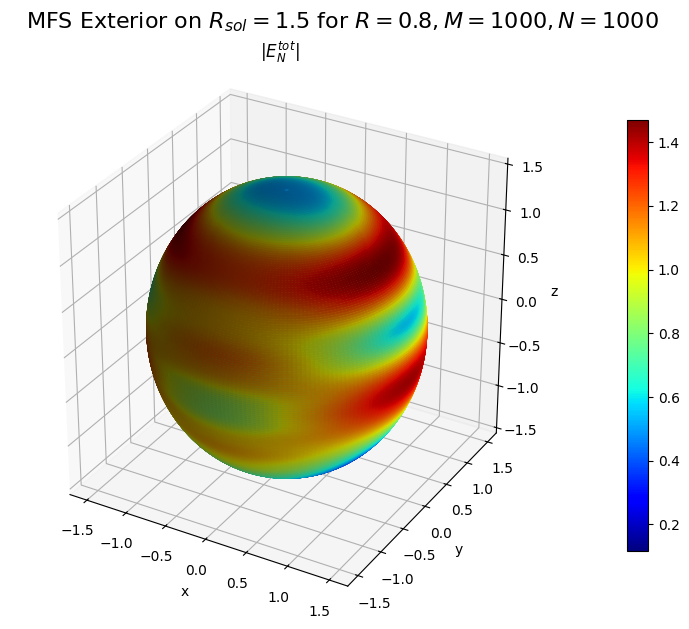

In [8]:
# Create a meshgrid of points on the unit sphere for evaluation
R_sol = 1.5
n_grid = 200
theta = np.linspace(0, 2 * np.pi, n_grid)
phi = np.linspace(0, np.pi, n_grid)
theta, phi = np.meshgrid(theta, phi)
x_plot = R_sol * np.sin(phi) * np.cos(theta)
y_plot = R_sol * np.sin(phi) * np.sin(theta)
z_plot = R_sol * np.cos(phi)
pts = np.stack((x_plot, y_plot, z_plot), axis=-1).reshape(-1, 3)  # (P, 3)

def eval_scattered(pts, y, alpha, batch=1000):
    """
    Evaluate the scattered field u_sc at pts
      pts   : (P, 3) evaluation points
      y     : (N, 3) source locations
      alpha : (N, 3) coefficients
      batch : number of points to process per batch
    Returns an array of shape (P, 3) for the scattered field
    """
    P = pts.shape[0]
    u_sc = np.empty((P, 3), dtype=complex)
    for i in range(0, P, batch):
        end = i + batch
        u_sc[i:end] = (fs(pts[i:end], y)
                      @ alpha[None, :, :, None]).sum(axis=1).squeeze(-1)
    return u_sc

# Compute the approximated scattered field u_sc^(N)
u_sc = eval_scattered(pts, y, alpha)

# Compute total field
u_tot = E(pts) + u_sc  # (P, 3)
f = np.linalg.norm(u_tot, axis=1).reshape(n_grid, n_grid)

# Colour normalisation that spans the global min/max
norm = colors.Normalize(vmin=f.min(), vmax=f.max())

# Prepare subplot
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
fig.suptitle(f"MFS Exterior on $R_{{sol}}={R_sol}$ for $R={R}, M={M}, N={N}$",
             fontsize=16, y=0.96)

# Plot the surface
ax.plot_surface(
  x_plot, y_plot, z_plot,
  facecolors=plt.cm.jet(norm(f)),
  rstride=1, cstride=1, antialiased=True, alpha=0.9
)

# Set plot title and axis labels
ax.set(title="$|E_N^{tot}|$", xlabel='x', ylabel='y', zlabel='z')
ax.set_box_aspect([1, 1, 1])

# Add colorbar
cbar = fig.colorbar(
  plt.cm.ScalarMappable(cmap='jet', norm=norm),
  ax=ax, pad=0.1, shrink=0.8
)
plt.show()

<ipython-input-9-4f9fc9a6eb1b>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.93])


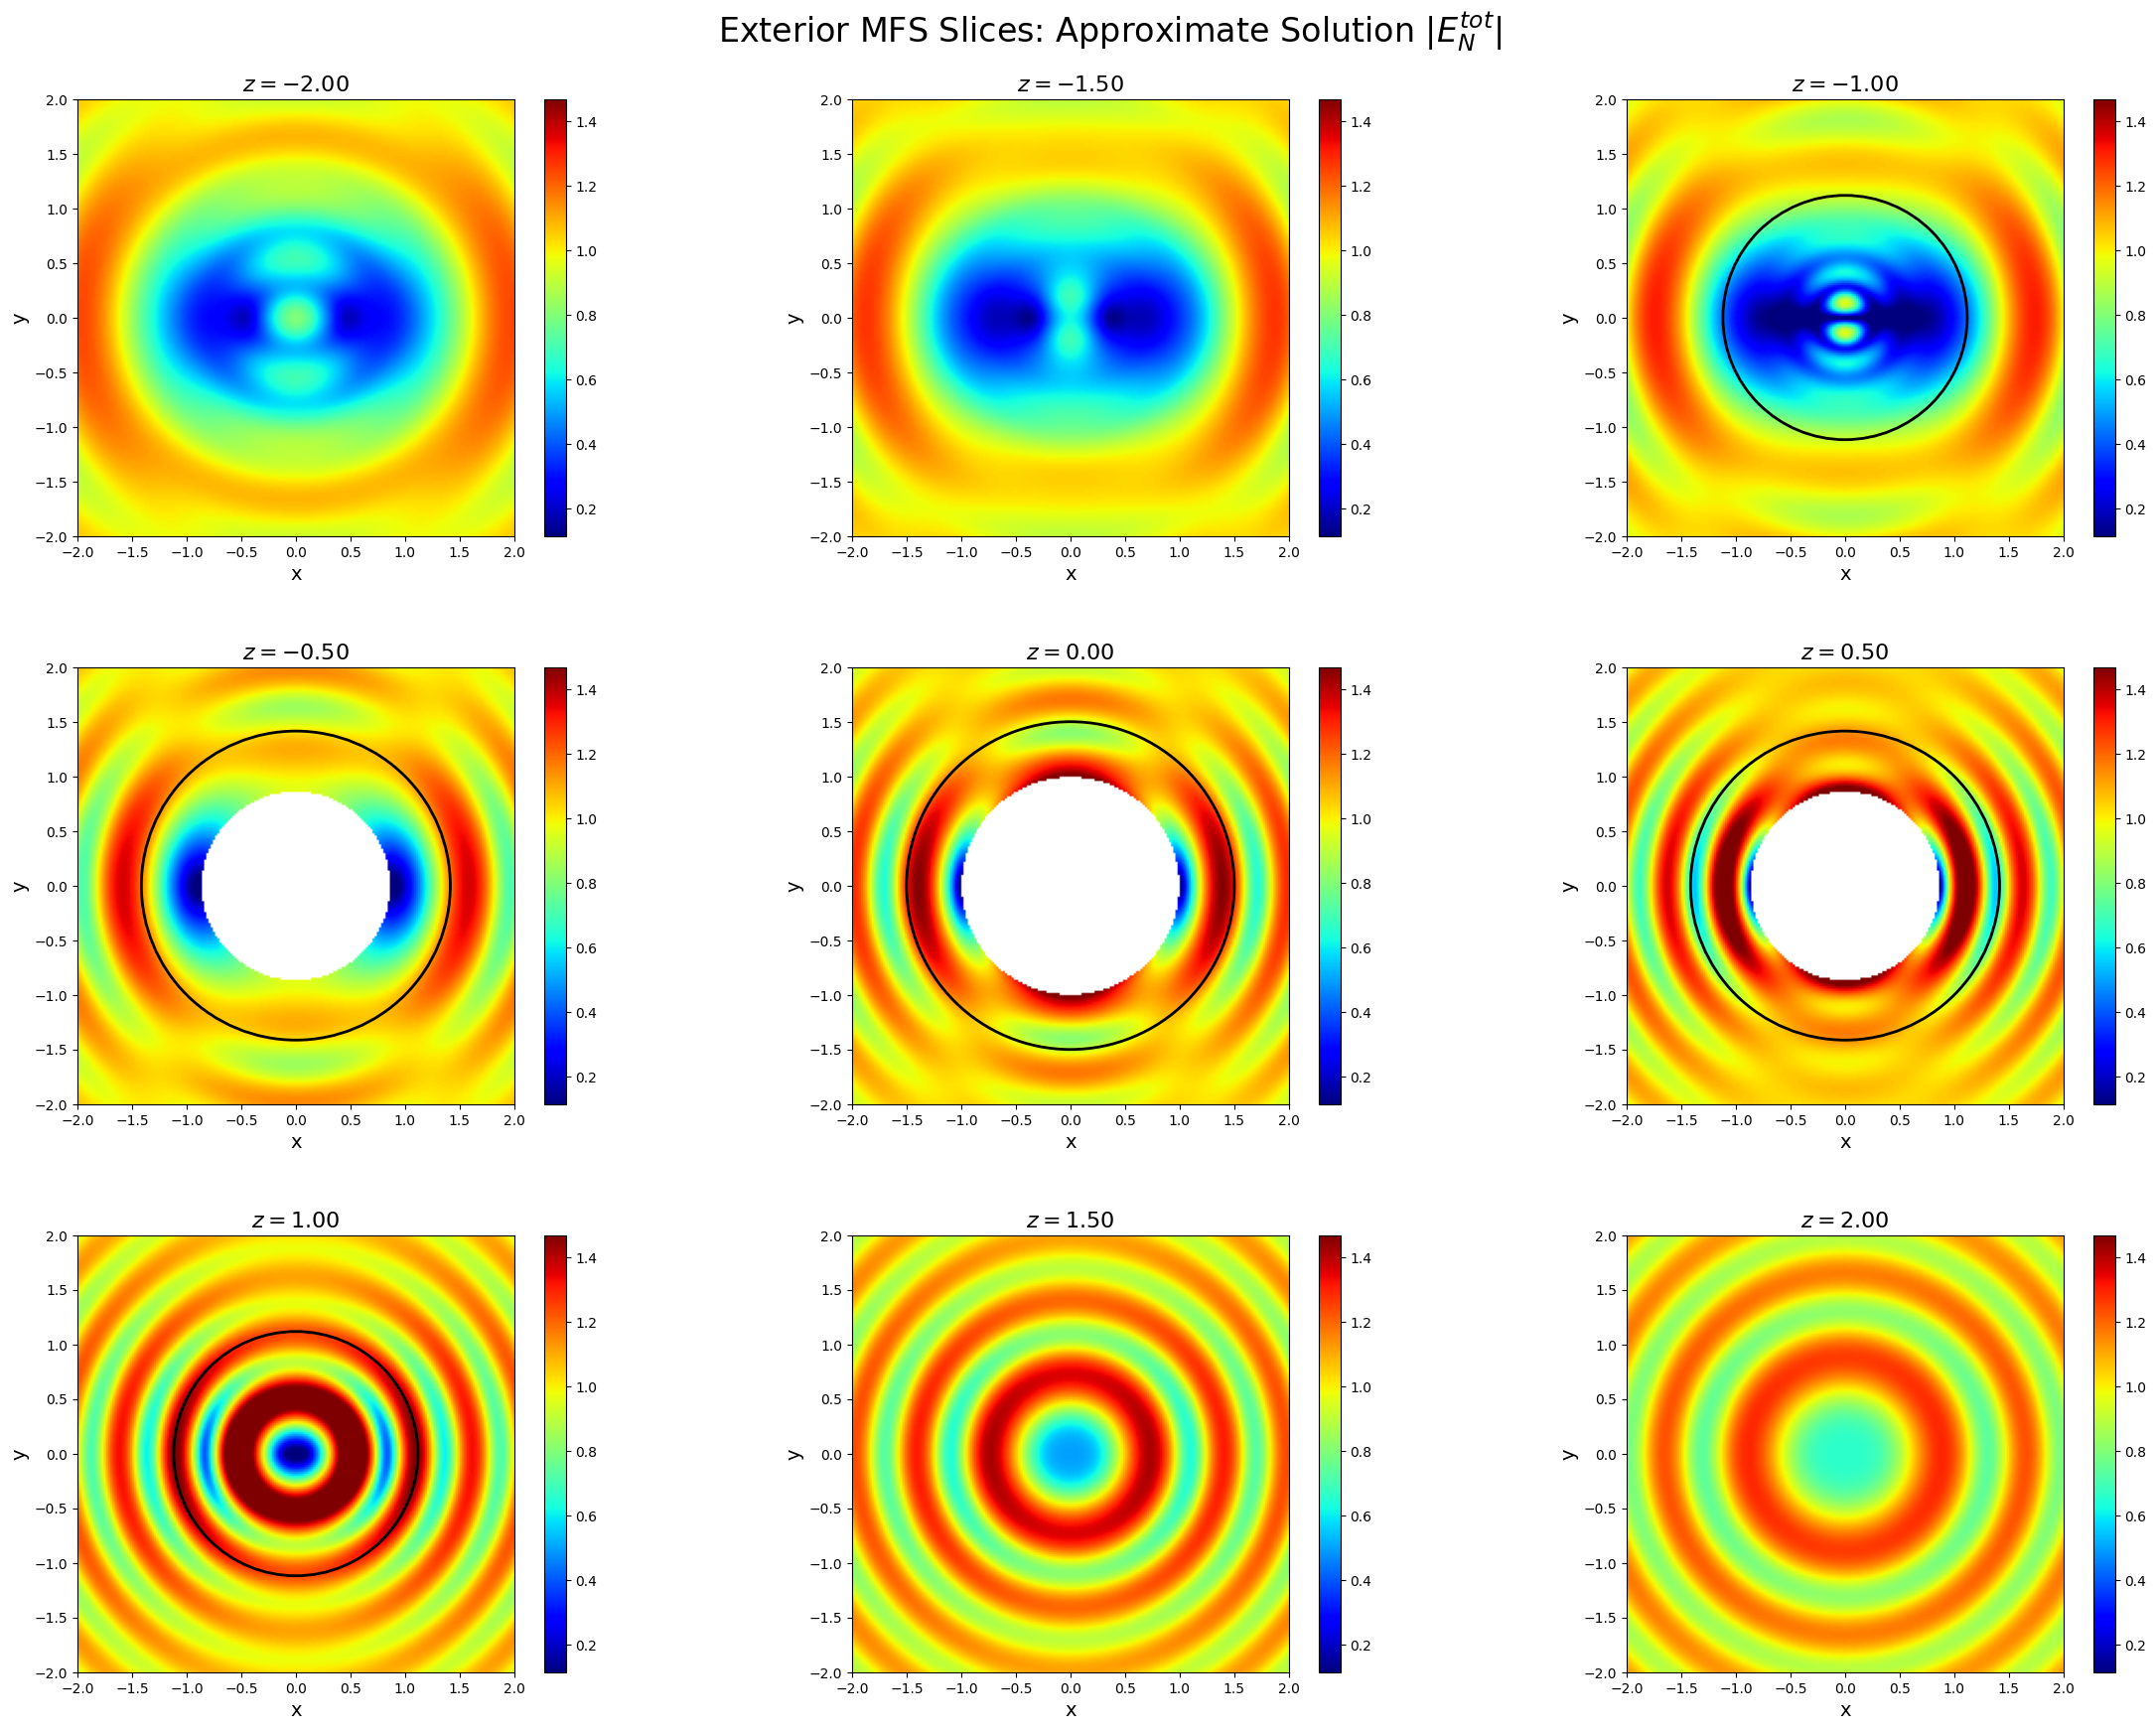

In [9]:
n_slices = 9
z_vals = np.linspace(-2, 2, n_slices)
n_grid = 200
xmin, xmax = -2, 2
ymin, ymax = -2, 2
xvals = np.linspace(xmin, xmax, n_grid)
yvals = np.linspace(ymin, ymax, n_grid)
X, Y = np.meshgrid(xvals, yvals)

# Set up the figure using GridSpec for the layout.
fig = plt.figure(figsize=(24, 18))
outer_gs = GridSpec(3, 3, left=0.05, right=0.95, top=0.93, bottom=0.05,
                     wspace=0.3, hspace=0.3)

cmap = plt.cm.jet
cmap.set_bad(color='white')

for i, z in enumerate(z_vals):
  ax = fig.add_subplot(outer_gs[i])

  pts_slice = np.column_stack((X.ravel(), Y.ravel(), np.full(X.size, z)))
  u_sc_slice = eval_scattered(pts_slice, y, alpha)
  u_tot_slice = E(pts_slice) + u_sc_slice
  f_slice = np.linalg.norm(u_tot_slice, axis=1).reshape(X.shape)

  # Mask points inside the sphere
  R_pts = np.sqrt(X**2 + Y**2 + z**2)
  f_mask = np.ma.array(f_slice, mask=(R_pts < 1))

  im = ax.imshow(f_mask, extent=[xmin, xmax, ymin, ymax],
                  origin='lower', cmap=cmap, norm=norm)

  # Add an outline circle
  circle = plt.Circle((0, 0), np.sqrt(max(0, R_sol**2 - z**2)),
                      color='black', fill=False, lw=2, zorder=10)
  ax.add_patch(circle)

  # Set title and labels
  ax.set_title(f"$z={z:.2f}$", fontsize=16)
  ax.set_xlabel('x', fontsize=14)
  ax.set_ylabel('y', fontsize=14, labelpad=4)
  fig.colorbar(im, ax=ax, pad=0.05)

fig.suptitle("Exterior MFS Slices: Approximate Solution $|E^{tot}_N|$",
             fontsize=24, y=0.98)
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.93])
plt.show()